In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy
import json
import torch
import torch.nn as nn
from scipy.io.wavfile import read
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import Sampler
import torchaudio

In [4]:
manifest_path = 'DCB_manifest.csv'
manifest = pd.read_csv(manifest_path).iloc[:10]
manifest.head()

,wav_file,txt_file,groundtruth_text,duration,age,gender
0,data_processed_DCB/wav/DCB_se1_ag1_m_01_1_part...,data_processed_DCB/txt/DCB_se1_ag1_m_01_1_part...,"Uh, I want to- I'm going to pursue IT. And I'm...",13.180,18,Male
1,data_processed_DCB/wav/DCB_se1_ag1_m_01_1_part...,data_processed_DCB/txt/DCB_se1_ag1_m_01_1_part...,showing that all young black men shouldn't go ...,21.988,18,Male
2,data_processed_DCB/wav/DCB_se1_ag1_m_01_1_part...,data_processed_DCB/txt/DCB_se1_ag1_m_01_1_part...,[And one-] And once you in college we will try...,5.134,18,Male
3,data_processed_DCB/wav/DCB_se1_ag1_m_01_1_part...,data_processed_DCB/txt/DCB_se1_ag1_m_01_1_part...,"Uh, well, basically as of today, Congress Heig...",30.588,18,Male
4,data_processed_DCB/wav/DCB_se1_ag1_m_01_1_part...,data_processed_DCB/txt/DCB_se1_ag1_m_01_1_part...,"Uh, I had /began before the street life/ for- ...",28.943,18,Male


## How we're currently processing audio

**Step 1: Use scipy.io.wavfile.read to read wav file**
**Step 2: Use scipy.io.wavfile.read to read wav file**

In [26]:
test_audio_path = manifest.iloc[0,0]
test_audio_path

'data_processed_DCB/wav/DCB_se1_ag1_m_01_1_part_1.wav'

In [29]:
1 << 16

65536

In [6]:
sample_rate, sound = read(test_audio_path)
print(sample_rate)

sound = sound.astype('float32') / 32767  # normalize audio
print(sound.shape)
if len(sound.shape) > 1:
    if sound.shape[1] == 1:
        sound = sound.squeeze()
    else:
        sound = sound.mean(axis=1)  # multiple channels, average

44100
(581242,)


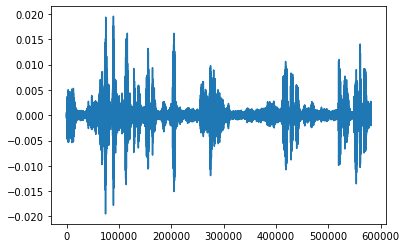

In [8]:
plt.figure()
plt.plot(sound)

In [16]:
window_size = 0.02
window_stride = 0.01
n_fft = int(sample_rate * window_size)
win_length = n_fft
hop_length = int(sample_rate * window_stride)
D = librosa.stft(sound, n_fft=n_fft, hop_length=hop_length,
                                 win_length=win_length, window=scipy.signal.hamming)
spect, phase = librosa.magphase(D)
# S = log(S + 1)
spect = np.log1p(spect)
spect = torch.FloatTensor(spect)
#Normalize spectrogram
mean = spect.mean()
std = spect.std()
spect.add_(-mean)
spect.div_(std)

tensor([[-0.1535, -0.1627, -0.1369,  ...,  0.3751, -0.0335, -0.1400],
        [-0.0065,  0.0300,  0.2192,  ...,  0.2438,  0.1821,  0.0498],
        [-0.1840,  0.3459,  0.7219,  ...,  0.7008,  0.0150, -0.0856],
        ...,
        [-0.2098, -0.2101, -0.2167,  ..., -0.2051, -0.2126, -0.2100],
        [-0.2076, -0.2055, -0.2152,  ..., -0.2069, -0.2136, -0.2064],
        [-0.1967, -0.2192, -0.1886,  ..., -0.2045, -0.2216, -0.1977]])

### Doing same thing with all librosa functions

In [37]:
import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

In [39]:
test_audio = manifest.iloc[0]
test_audio_path = test_audio[0]
test_audio

wav_file            data_processed_DCB/wav/DCB_se1_ag1_m_01_1_part...
txt_file            data_processed_DCB/txt/DCB_se1_ag1_m_01_1_part...
groundtruth_text    Uh, I want to- I'm going to pursue IT. And I'm...
duration                                                        13.18
age                                                                18
gender                                                           Male
Name: 0, dtype: object

(581242,)
581238.0


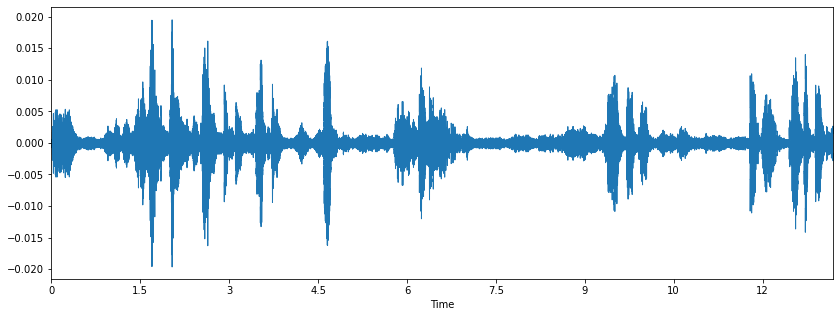

In [40]:
sound, sample_rate = librosa.load(test_audio_path, sr = 44100)
print(sound.shape)
print(44100*test_audio.duration)
plt.figure(figsize=(14, 5))

librosa.display.waveplot(sound, sr=sample_rate)

(581242,)


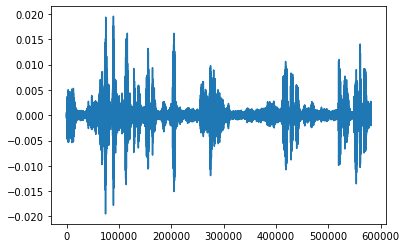

In [34]:
#plot corresponding spectrogram

In [45]:
window_size = 0.02
window_stride = 0.01
sample_rate = 44100
n_fft = 1024
print(n_fft)
hop_length = int(sample_rate * window_stride)
print(hop_length)

882
441


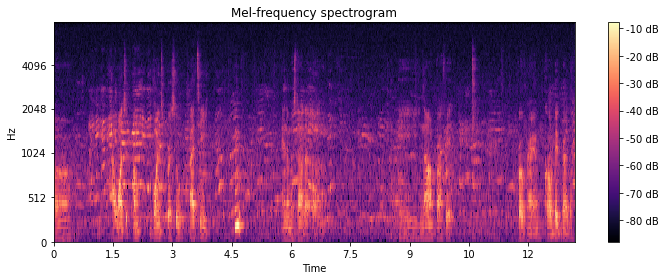

In [52]:
#extract mfcc features
mel_spect = librosa.feature.melspectrogram(sound, sr = sample_rate, n_fft = n_fft)
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(mel_spect)
librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sample_rate, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [56]:
mfcc_features_manual = librosa.feature.mfcc(S=S_dB, n_mfcc = 40)#, n_fft = n_fft)
print(mfcc_features_manual.shape)
mfcc_features_manual

(40, 1136)


array([[-7.75232849e+02, -7.12208252e+02, -6.96312012e+02, ...,
        -6.89566406e+02, -6.97195679e+02, -6.94744385e+02],
       [ 1.20122528e+02,  1.47374268e+02,  1.72399612e+02, ...,
         1.32795532e+02,  1.26378250e+02,  1.18643616e+02],
       [ 2.15504646e+01, -6.19376802e+00,  1.34403973e+01, ...,
        -4.54340439e+01, -4.63670578e+01, -5.81554260e+01],
       ...,
       [ 6.32590580e+00,  4.14726830e+00,  3.09345722e+00, ...,
         1.91492164e+00,  2.33373380e+00,  4.51927757e+00],
       [ 5.01702785e+00, -2.12584066e+00,  9.45095062e-01, ...,
        -8.56629753e+00, -1.26665478e+01, -7.52031565e+00],
       [ 4.19730616e+00,  5.69930375e-01,  3.96044636e+00, ...,
        -6.85751319e-01, -6.50126505e+00, -5.15399027e+00]], dtype=float32)

In [58]:
mfcc_features_auto = librosa.feature.mfcc(sound, sr = sample_rate, n_mfcc = 40, n_fft = n_fft, window = scipy.signal.hamming)
print(mfcc_features_auto.shape)
mfcc_features_auto

(40, 1136)


array([[-7.7205945e+02, -7.0955560e+02, -6.9118140e+02, ...,
        -6.8764581e+02, -6.9545142e+02, -6.9394293e+02],
       [ 1.1909446e+02,  1.4705481e+02,  1.6988901e+02, ...,
         1.3156375e+02,  1.2427127e+02,  1.1639220e+02],
       [ 1.9935417e+01, -5.7900214e+00,  1.1980628e+01, ...,
        -4.5410446e+01, -4.8624725e+01, -5.9242767e+01],
       ...,
       [ 5.6202817e+00,  3.9950988e+00,  3.2671638e+00, ...,
         1.4266539e+00,  2.5581160e+00,  3.1162395e+00],
       [ 5.0734568e+00, -2.5209260e+00,  1.3094473e+00, ...,
        -9.2385931e+00, -1.3357906e+01, -9.1649551e+00],
       [ 6.4066553e+00, -1.4148606e-01,  3.5125861e+00, ...,
        -8.9876246e-01, -7.8157134e+00, -7.3280220e+00]], dtype=float32)

# What is going wrong in the VOC dataset?

In [5]:
#list of files with very high loss numbers
examples = [
    '../data_processed_voc/wav/voc_33_part_3.wav', #Transcript: UM
    '../data_processed_voc/wav/voc_2_part_1.wav', #Transcript: UM
    '../data_processed_voc/wav/voc_12_part_198.wav', # KILL
    '../data_processed_voc/wav/voc_0_part_330.wav', #KILL
    '../data_processed_voc/wav/voc_0_part_328.wav', # Basically silent
    '../data_processed_voc/wav/voc_10_part_414.wav', # Basically silent
    '../data_processed_voc/wav/voc_10_part_404.wav', #Transcript: UM
    '../data_processed_voc/wav/voc_2_part_4.wav', #Transcript: UM YEAH SURE
    '../data_processed_voc/wav/voc_8_part_228.wav', #KILL
    '../data_processed_voc/wav/voc_26_part_207.wav', #Transcript: Incorrect
    '../data_processed_voc/wav/voc_13_part_234.wav', #Transcript: Incorrect
    '../data_processed_voc/wav/voc_12_part_185.wav' #KILL
]

## Recreate featurization that occurs in data loader

In [19]:
audio_conf = {
    'sample_rate': 44100,  # The sample rate for the data/model features
    'window_size': 0.02,  # Window size for spectrogram generation (seconds)
    'window_stride': 0.01,  # Window stride for spectrogram generation (seconds)
    'n_fft': 1024, #sample_rate*window_size rounded to nearest power of 2, for efficiency
    'window':scipy.signal.hamming
}

def load_audio(audio_path):
    #returns audio time series with length duration*sample_rate
    sound, sample_rate = librosa.load(audio_path, sr = audio_conf['sample_rate'])
    return sound

def get_spectrogram(sound):
    n_fft = audio_conf['n_fft']
    win_length = n_fft
    hop_length = int(audio_conf['sample_rate'] * audio_conf['window_stride'])
    #Return complex values spectrogram (D) - Short Time Fourier Transform
    D = librosa.stft(sound, n_fft=n_fft, hop_length=hop_length,
                                 win_length=win_length, window = audio_conf['window'])
    #Transofrms D into its magnitude and phase components
    spect, phase = librosa.magphase(D)
    # S = log(S + 1)
    spect = np.log1p(spect)
    spect = torch.FloatTensor(spect)
    #Normalize spectrogram
    mean = spect.mean()
    std = spect.std()
    spect.add_(-mean)
    spect.div_(std)
    return spect

max: 73.92042541503906, min: -0.31053268909454346 mean: -2.0166353920103575e-07, std: 0.999999463558197


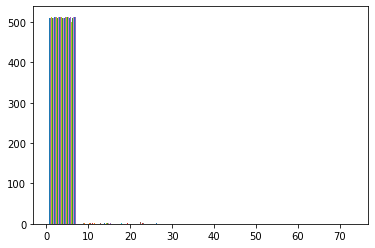

max: 36.230098724365234, min: -0.19263839721679688 mean: -7.72306307794679e-09, std: 0.9999991059303284


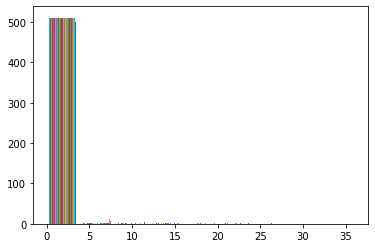

max: 31.43748664855957, min: -0.324398010969162 mean: 3.484286636989964e-08, std: 0.9999995231628418


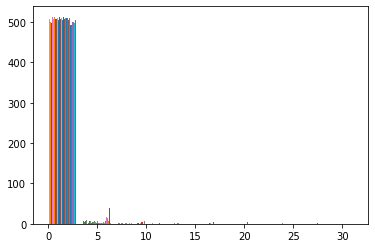

max: 45.59727096557617, min: -0.25336921215057373 mean: -2.3603145393735758e-07, std: 0.9999993443489075


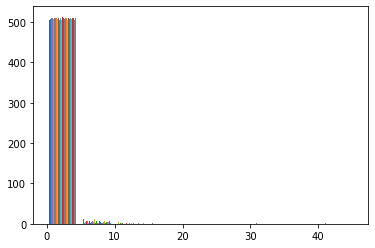

max: 48.23847198486328, min: -0.2291611284017563 mean: -2.0531196298634313e-07, std: 0.9999994039535522


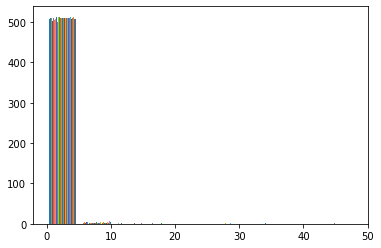

max: 58.84121322631836, min: -0.14552709460258484 mean: 1.918357384056435e-08, std: 0.9999992251396179


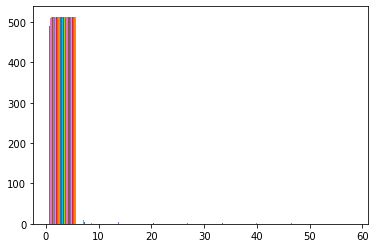

max: 44.02461624145508, min: -0.16858524084091187 mean: -9.64378088497142e-08, std: 0.9999988675117493


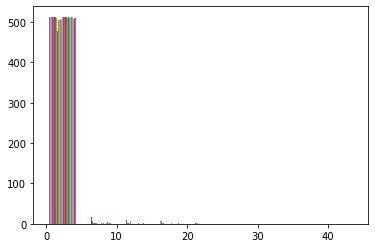

max: 36.595375061035156, min: -0.17163358628749847 mean: -4.370275807907831e-10, std: 0.9999994039535522


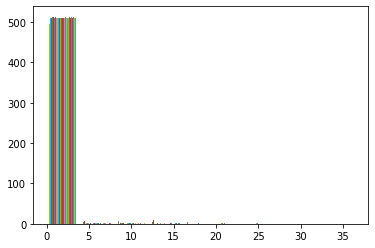

max: 17.124284744262695, min: -0.2777499556541443 mean: 6.239578453914874e-08, std: 0.9999995827674866


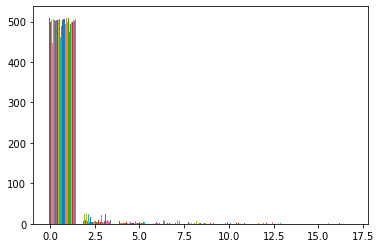

max: 53.431922912597656, min: -0.24437326192855835 mean: -1.6330285745880246e-07, std: 0.9999998211860657


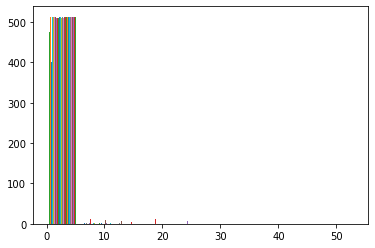

max: 16.69375228881836, min: -0.25137004256248474 mean: -8.220275304893221e-08, std: 0.9999995827674866


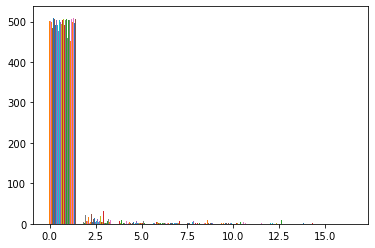

max: 36.17627716064453, min: -0.35788509249687195 mean: 3.337840155381855e-07, std: 0.9999997019767761


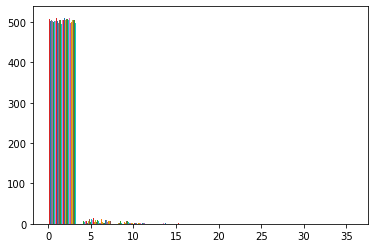

In [30]:
for example in examples:
    audio_path = example
    sound = load_audio(audio_path)
    spect = get_spectrogram(sound).numpy()
    print('max: {}, min: {} mean: {}, std: {}'.format(np.max(spect), np.min(spect), np.mean(spect), np.std(spect)))
    bins = np.linspace(np.min(spect), np.max(spect), 10)
    plt.hist(spect, bins = bins)
    plt.show()

max: 21.474340438842773, min: -0.2137555032968521 mean: 8.843800003432989e-08, std: 0.9999993443489075


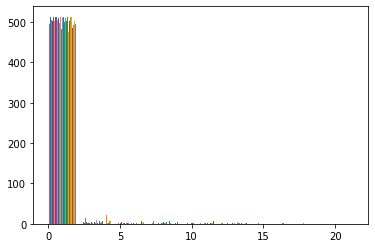

max: 20.04395294189453, min: -0.21121527254581451 mean: 1.0628604485418691e-07, std: 0.9999983310699463


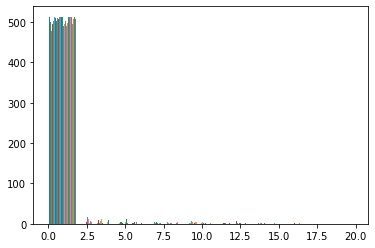

max: 19.74946403503418, min: -0.2523020803928375 mean: 4.7985944107153955e-09, std: 0.999998927116394


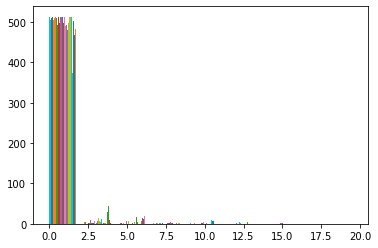

In [32]:
normal_examples = ['../data_processed_voc/wav/voc_0_part_10.wav',
                  '../data_processed_voc/wav/voc_0_part_11.wav',
                  '../data_processed_voc/wav/voc_0_part_12.wav']

for example in normal_examples:
    audio_path = example
    sound = load_audio(audio_path)
    spect = get_spectrogram(sound).numpy()
    print('max: {}, min: {} mean: {}, std: {}'.format(np.max(spect), np.min(spect), np.mean(spect), np.std(spect)))
    bins = np.linspace(np.min(spect), np.max(spect), 10)
    plt.hist(spect, bins = bins)
    plt.show()